# Diabetes

## Introducción

En este notebook, vamos a realizar un análisis exploratorio de datos y desarrollaremos una red neuronal profunda usando PyTorch para predecir la progresión de la enfermedad de diabetes.

El conjunto de datos que utilizaremos es el "Diabetes Dataset" de sklearn, que contiene información de 442 pacientes. La variable objetivo es una medida cuantitativa de la progresión de la enfermedad un año después del inicio del estudio. Procederemos primero con un EDA para entender las características del conjunto de datos.

## Cargamos los datos

Primero, importamos las librerías necesarias y cargamos los datos del conjunto de datos de diabetes de sklearn. Convertimos los datos en un DataFrame para facilitar el análisis.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Cargar el conjunto de datos
diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target

# Convertir a DataFrame para facilitar el EDA
df = pd.DataFrame(X, columns=diabetes.feature_names)
df['target'] = y

## Análisis exploratorio

A continuación, realizamos un análisis estadístico descriptivo para entender mejor las características de los datos, como las medias, desviaciones estándar, y otros valores importantes.

In [2]:
print(df.describe())

                age           sex           bmi            bp            s1  \
count  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02   
mean  -2.511817e-19  1.230790e-17 -2.245564e-16 -4.797570e-17 -1.381499e-17   
std    4.761905e-02  4.761905e-02  4.761905e-02  4.761905e-02  4.761905e-02   
min   -1.072256e-01 -4.464164e-02 -9.027530e-02 -1.123988e-01 -1.267807e-01   
25%   -3.729927e-02 -4.464164e-02 -3.422907e-02 -3.665608e-02 -3.424784e-02   
50%    5.383060e-03 -4.464164e-02 -7.283766e-03 -5.670422e-03 -4.320866e-03   
75%    3.807591e-02  5.068012e-02  3.124802e-02  3.564379e-02  2.835801e-02   
max    1.107267e-01  5.068012e-02  1.705552e-01  1.320436e-01  1.539137e-01   

                 s2            s3            s4            s5            s6  \
count  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02   
mean   3.918434e-17 -5.777179e-18 -9.042540e-18  9.293722e-17  1.130318e-17   
std    4.761905e-02  4.761905e-02  4.761905e-02  4.

Para entender mejor la distribución de las variables, trazamos histogramas para cada una de ellas. Esto nos ayudará a detectar posibles sesgos, asimetrías, o valores atípicos.

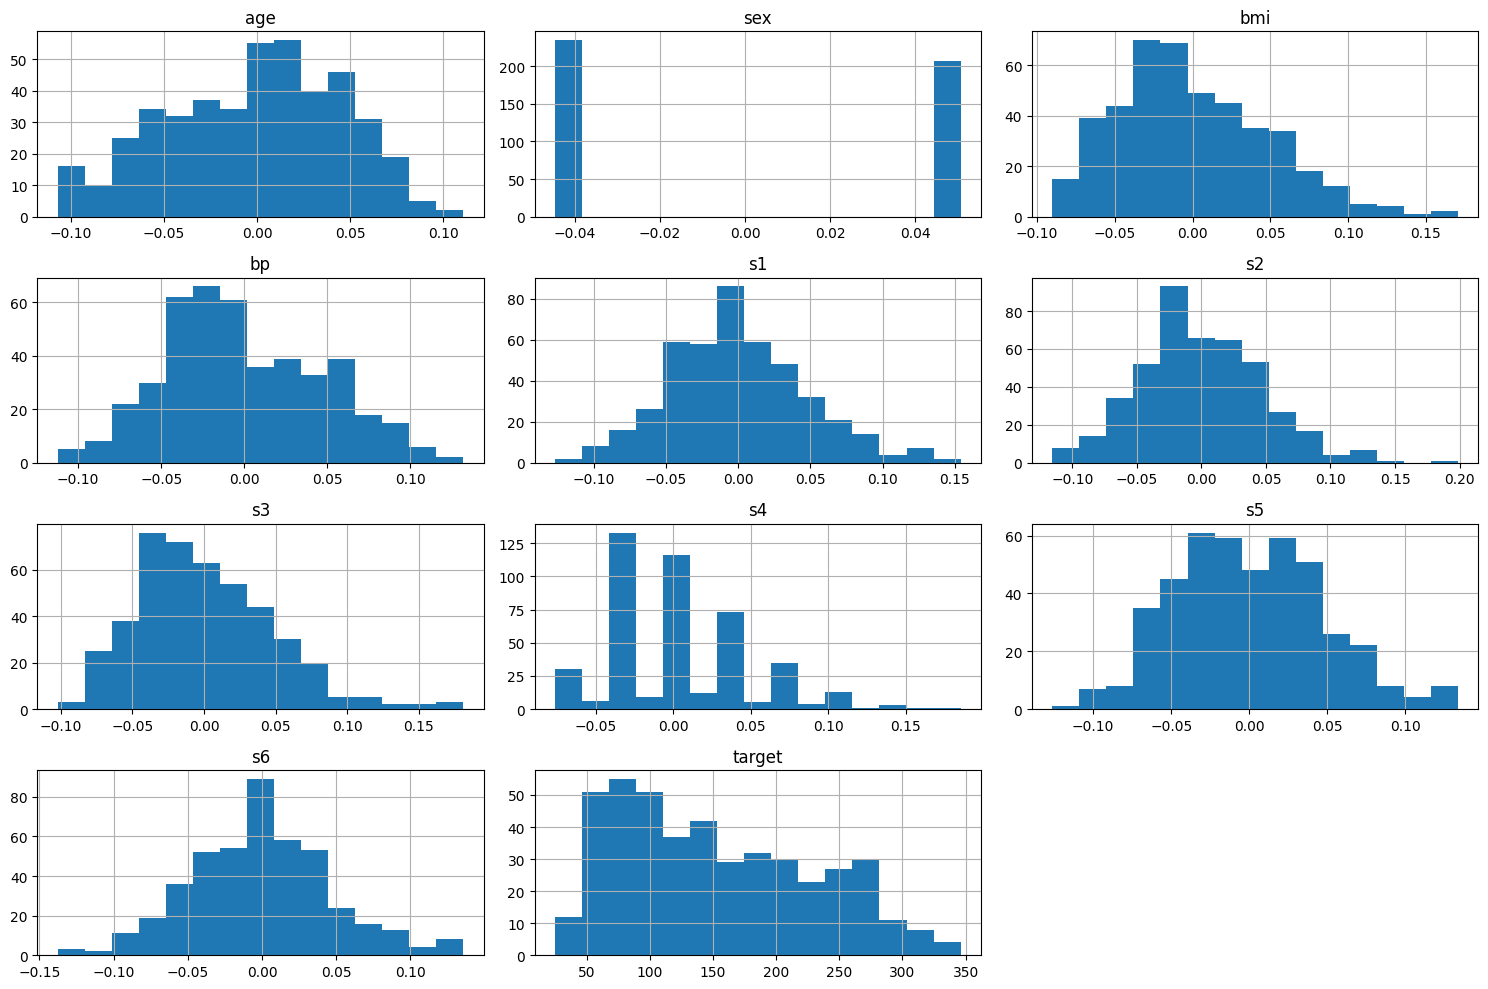

In [3]:
df.hist(bins=15, figsize=(15,10))
plt.tight_layout()
plt.show()

Ahora evaluaremos la correlación entre las diferentes variables del conjunto de datos y la variable objetivo. Utilizamos un mapa de calor para visualizar la matriz de correlación.

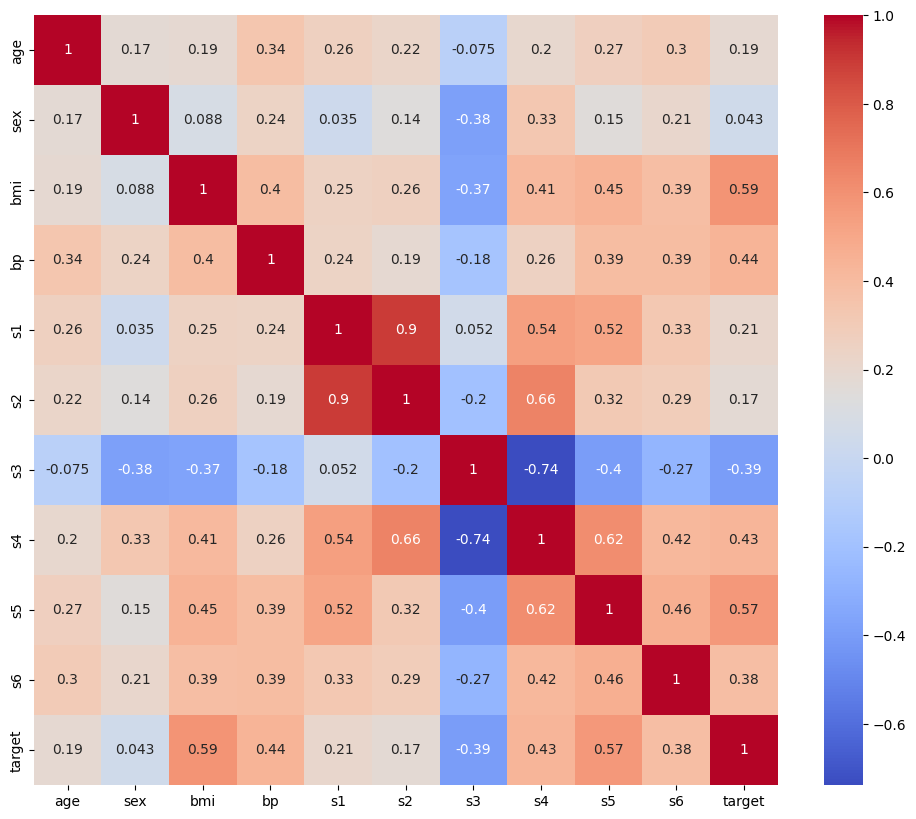

target    1.000000
bmi       0.586450
s5        0.565883
bp        0.441482
s4        0.430453
s6        0.382483
s1        0.212022
age       0.187889
s2        0.174054
sex       0.043062
s3       -0.394789
Name: target, dtype: float64


In [4]:
# Correlación con la variable objetivo
corr_matrix = df.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

# Correlación específica con la variable objetivo
corr_target = corr_matrix['target'].sort_values(ascending=False)
print(corr_target)

## Anáisis usando pytorch

Una vez realizado el análisis exploratorio, procedemos a preparar los datos para entrenar la red neuronal.

Dividimos el conjunto de datos en entrenamiento y prueba. Luego, estandarizamos los datos usando `StandardScaler` para que todas las características tengan una media de 0 y una desviación estándar de 1.

In [5]:
# Preparación de los datos
# Separar características y etiqueta
X = df.drop('target', axis=1).values
y = df['target'].values.reshape(-1, 1)

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Estandarizar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convertir a tensores
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

# Crear DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Definimos la estructura de la red neuronal profunda. La red tendrá tres capas completamente conectadas (fully connected layers) con activaciones ReLU. La última capa tiene una salida unitaria para predecir la progresión de la enfermedad.

In [6]:
# Definición de la red neuronal
class DiabetesNet(nn.Module):
    def __init__(self, n1=64, n2=32):
        super(DiabetesNet, self).__init__()
        self.fc1 = nn.Linear(10, n1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(n1, n2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(n2, 1)
    
    def forward(self, x):
        out = self.relu1(self.fc1(x))
        out = self.relu2(self.fc2(out))
        out = self.fc3(out)
        return out

Definimos la función de pérdida como el error cuadrático medio (MSE), y usamos el optimizador Adam para actualizar los pesos de la red durante el entrenamiento.

In [7]:
# Criterio y optimizador
model = DiabetesNet(64,32)

Entrenamos el modelo durante 100 épocas, registrando la pérdida para los conjuntos de entrenamiento y validación en cada época. Esto nos permitirá evaluar si el modelo está convergiendo correctamente.

In [8]:
# Entrenamiento del modelo
def train_model(model, num_epochs=1000, verbose=False):
    train_losses = []
    test_losses = []
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for features, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * features.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        
        # Evaluación en el conjunto de prueba
        model.eval()
        with torch.no_grad():
            test_running_loss = 0.0
            for features, labels in test_loader:
                outputs = model(features)
                loss = criterion(outputs, labels)
                test_running_loss += loss.item() * features.size(0)
            test_epoch_loss = test_running_loss / len(test_loader.dataset)
            test_losses.append(test_epoch_loss)
        
        if (epoch+1) % 100 == 0 and verbose:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Val Loss: {test_epoch_loss:.4f}')
    return train_losses, test_losses

train_losses, test_losses = train_model(model, num_epochs=100, verbose=True)

Epoch [100/100], Loss: 2883.8991, Val Loss: 2853.1495


Trazamos las curvas de pérdida para los conjuntos de entrenamiento y validación, lo cual nos permite visualizar cómo evoluciona la pérdida a medida que el modelo se entrena. Esto también nos permite evaluar si el modelo sufre de sobreajuste.

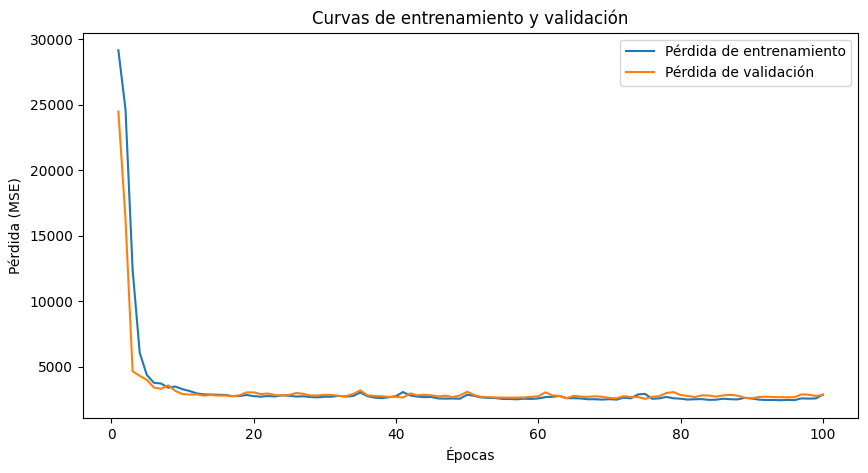

In [9]:
# Curvas de entrenamiento
plt.figure(figsize=(10,5))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Pérdida de entrenamiento')
plt.plot(range(1, len(test_losses)+1), test_losses, label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (MSE)')
plt.title('Curvas de entrenamiento y validación')
plt.legend()
plt.show()

Después del entrenamiento, evaluamos el desempeño del modelo usando las métricas R2, MAE y MSE. Estas métricas nos ayudan a entender qué tan bien está funcionando el modelo.

In [10]:
from sklearn.metrics import r2_score, mean_absolute_error

def get_metrics(model, X_test_tensor, y_test, verbose=True):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor).numpy()
        true_values = y_test
        
        r2 = r2_score(true_values, predictions)
        mae = mean_absolute_error(true_values, predictions)
        criterion = nn.MSELoss()
        mse = criterion(torch.FloatTensor(predictions), torch.FloatTensor(true_values)).item()

    if verbose:
        print(f'Coeficiente de determinación R2: {r2:.4f}')
        print(f'Error absoluto medio MAE: {mae:.4f}')
        print(f'Error cuadrático medio MSE: {mse:.4f}')
    return r2, mae, mse

get_metrics(model, X_test_tensor, y_test)

Coeficiente de determinación R2: 0.4615
Error absoluto medio MAE: 41.9759
Error cuadrático medio MSE: 2853.1494


(0.46148210891764463, 41.97593611813663, 2853.1494140625)

Por último, trazamos un gráfico de dispersión para comparar los valores reales de la progresión de la enfermedad frente a los valores predichos por el modelo. Esto nos da una mejor idea visual del rendimiento del modelo.

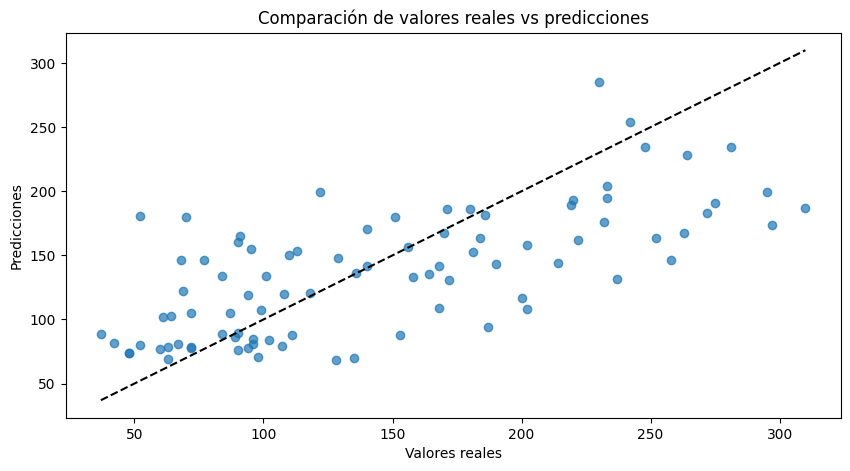

In [11]:
predictions = model(X_test_tensor).detach().numpy()
true_values = y_test
plt.figure(figsize=(10,5))
plt.scatter(true_values, predictions, alpha=0.7)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Comparación de valores reales vs predicciones')
plt.plot([true_values.min(), true_values.max()], [true_values.min(), true_values.max()], 'k--')
plt.show()

# Prueba de sobreentrenamiento y evaluación de sesgo y varianza

In [12]:
X = df.drop('target', axis=1).values
y = df['target'].values.reshape(-1, 1)

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Estandarizar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convertir a tensores
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

# Crear DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Definamos difererens modelos más simples o más complejos

In [13]:
n_epochs = 600

# Modelo súper simple
model_0 = DiabetesNet(4,2)
train_losses_0, test_losses_0 = train_model(model_0, num_epochs=n_epochs, verbose=False)
r20, mae0, mse0 = get_metrics(model_0, X_test_tensor, y_test, verbose=False)
r20_train, mae0_train, mse0_train = get_metrics(model_0, X_train_tensor, y_train, verbose=False)

# Modelo intermedio
model_1 = DiabetesNet(16,8)
train_losses_1, test_losses_1 = train_model(model_1, num_epochs=n_epochs, verbose=False)
r21, mae1, mse1 = get_metrics(model_1, X_test_tensor, y_test, verbose=False)
r21_train, mae1_train, mse1_train = get_metrics(model_1, X_train_tensor, y_train, verbose=False)

# Modelo complejo
model_2 = DiabetesNet(64,32)
train_losses_2, test_losses_2 = train_model(model_2, num_epochs=n_epochs, verbose=False)
r22, mae2, mse2 = get_metrics(model_2, X_test_tensor, y_test, verbose=False)
r22_train, mae2_train, mse2_train = get_metrics(model_2, X_train_tensor, y_train, verbose=False)

# Modelo super complejo
model_3 = DiabetesNet(128,64)
train_losses_3, test_losses_3 = train_model(model_3, num_epochs=n_epochs, verbose=False)
r23, mae3, mse3 = get_metrics(model_3, X_test_tensor, y_test, verbose=False)
r23_train, mae3_train, mse3_train = get_metrics(model_3, X_train_tensor, y_train, verbose=False)

### Comparemos las curvas de entrenamiento

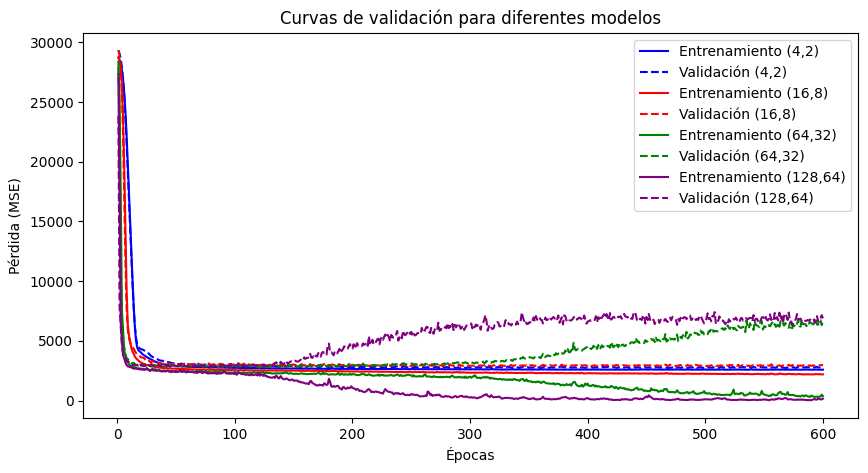

In [14]:
plt.figure(figsize=(10,5))
plt.xlabel('Épocas')
plt.ylabel('Pérdida (MSE)')
plt.title('Curvas de validación para diferentes modelos')
tl0 = test_losses_0[::1] # smooth out the curve
tl1 = test_losses_1[::1]
tl2 = test_losses_2[::1]
tl3 = test_losses_3[::1]
tr0 = train_losses_0[::1]
tr1 = train_losses_1[::1]
tr2 = train_losses_2[::1]
tr3 = train_losses_3[::1]
# plot train as solid lines and test as dashed
plt.plot(range(1, len(tr0)+1), tr0, label='Entrenamiento (4,2)', color='blue')
plt.plot(range(1, len(tl0)+1), tl0, label='Validación (4,2)', color='blue', linestyle='--')
plt.plot(range(1, len(tr1)+1), tr1, label='Entrenamiento (16,8)', color='red')
plt.plot(range(1, len(tl1)+1), tl1, label='Validación (16,8)', color='red', linestyle='--')
plt.plot(range(1, len(tr2)+1), tr2, label='Entrenamiento (64,32)', color='green')
plt.plot(range(1, len(tl2)+1), tl2, label='Validación (64,32)', color='green', linestyle='--')
plt.plot(range(1, len(tr3)+1), tr3, label='Entrenamiento (128,64)', color='purple')
plt.plot(range(1, len(tl3)+1), tl3, label='Validación (128,64)', color='purple', linestyle='--')

plt.legend()

### Vamos a comparar las métricas

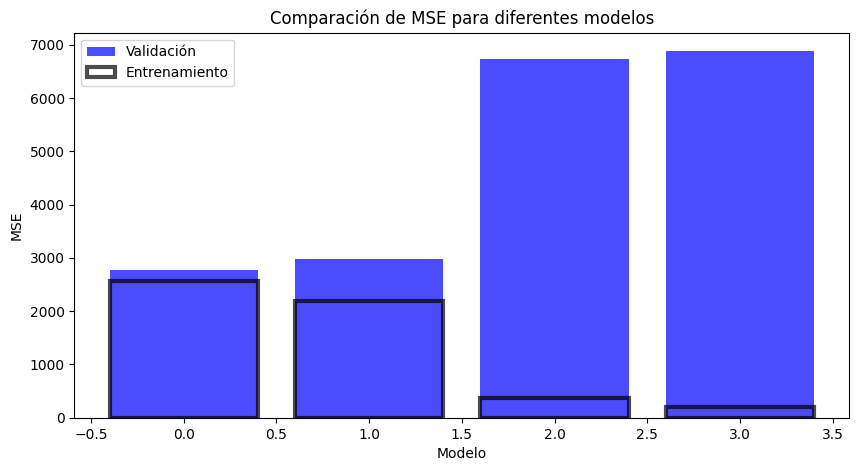

In [15]:
# Plot the mse values for train and test
plt.figure(figsize=(10,5))
plt.xlabel('Modelo')
plt.ylabel('MSE')
plt.title('Comparación de MSE para diferentes modelos')
# plot both train and test as bars with no fill
plt.bar([0,1,2,3], [mse0, mse1, mse2, mse3], label='Validación', color='blue', fill=True, lw=3, alpha=0.7)
plt.bar([0,1,2,3], [mse0_train, mse1_train, mse2_train, mse3_train], label='Entrenamiento', color='red', fill=False, lw=3, alpha=0.7)
plt.legend()


plt.show()

## Vamos a calcular la varianza

In [16]:
# Vamos a calcular la varianza usando el dataset de test dividido en 5 sub-datasets
def variance(model, X_test, y_test):
    predictions = model(X_test).detach().numpy()
    true_values = np.array(y_test)
    var = np.var(predictions - true_values)
    return var

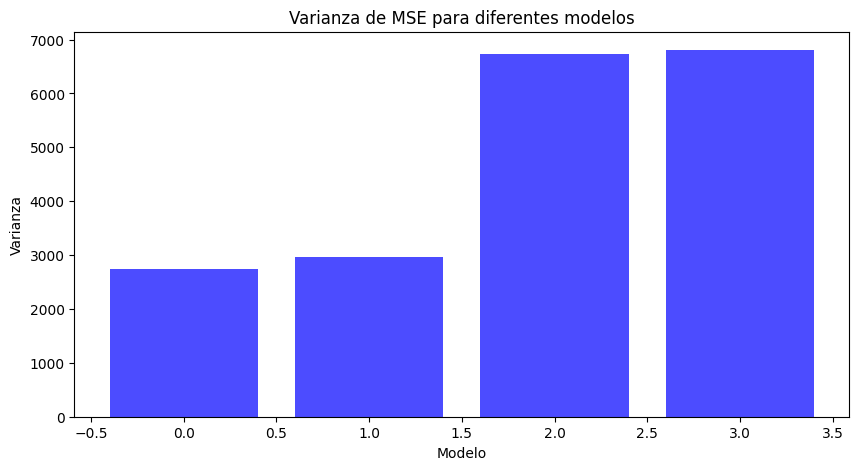

In [17]:
vars = []
for model in [model_0, model_1, model_2, model_3]:
    var = variance(model, X_test_tensor, y_test)
    vars.append(var)

plt.figure(figsize=(10,5))
plt.xlabel('Modelo')
plt.ylabel('Varianza')
plt.title('Varianza de MSE para diferentes modelos')
plt.bar([0,1,2,3], vars, color='blue', fill=True, lw=3, alpha=0.7)
plt.show()

## Vamos a realizar el ejercicio para un array de complejidades de redes neuronales

In [18]:
model_complexity = np.arange(10, 200, 10, dtype=int)
vars = []
mse_test = []
mse_train = []
for i, n in enumerate(model_complexity):
    print(f'Training model with complexity {n} ({i+1}/{len(model_complexity)})...')
    model = DiabetesNet(n, n//2)
    train_losses, test_losses = train_model(model, num_epochs=400, verbose=False)
    r2, mae, mse = get_metrics(model, X_test_tensor, y_test, verbose=False)
    r2train, maetrain, msetrain = get_metrics(model, X_train_tensor, y_train, verbose=False)
    vars.append(variance(model, X_test_tensor, y_test))
    mse_test.append(mse)
    mse_train.append(msetrain)

Training model with complexity 10 (1/19)...
Training model with complexity 20 (2/19)...
Training model with complexity 30 (3/19)...
Training model with complexity 40 (4/19)...
Training model with complexity 50 (5/19)...
Training model with complexity 60 (6/19)...
Training model with complexity 70 (7/19)...
Training model with complexity 80 (8/19)...
Training model with complexity 90 (9/19)...
Training model with complexity 100 (10/19)...
Training model with complexity 110 (11/19)...
Training model with complexity 120 (12/19)...
Training model with complexity 130 (13/19)...
Training model with complexity 140 (14/19)...
Training model with complexity 150 (15/19)...
Training model with complexity 160 (16/19)...
Training model with complexity 170 (17/19)...
Training model with complexity 180 (18/19)...
Training model with complexity 190 (19/19)...


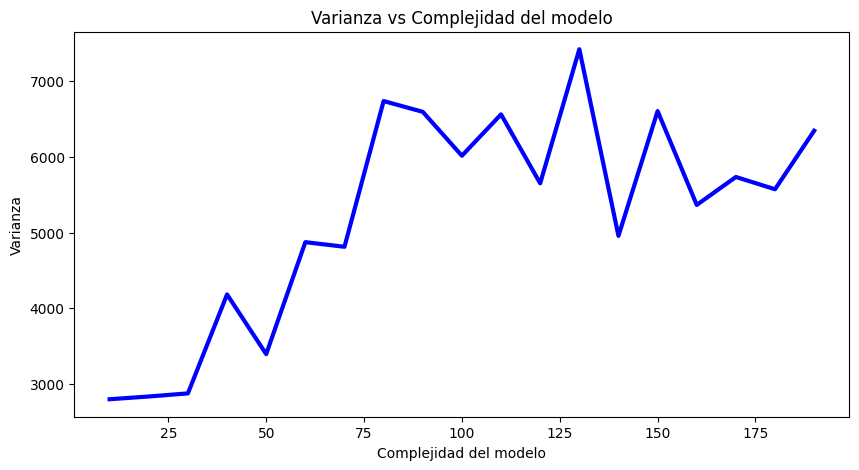

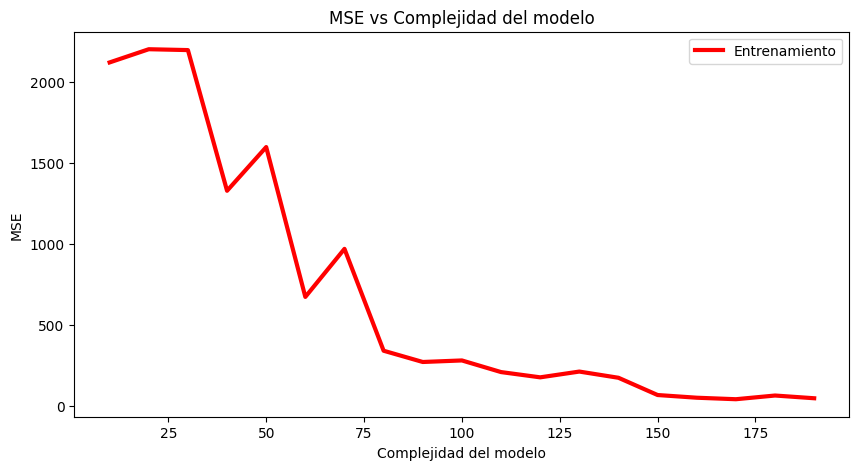

In [19]:
# plot var vs model complexity
plt.figure(figsize=(10,5))
plt.xlabel('Complejidad del modelo')
plt.ylabel('Varianza')
plt.title('Varianza vs Complejidad del modelo')
plt.plot(model_complexity, vars, color='blue', lw=3)
plt.show()

# plot mse vs model complexity
plt.figure(figsize=(10,5))
plt.xlabel('Complejidad del modelo')
plt.ylabel('MSE')
plt.title('MSE vs Complejidad del modelo')
plt.plot(model_complexity, mse_train, label='Entrenamiento', color='red', lw=3)
plt.legend()


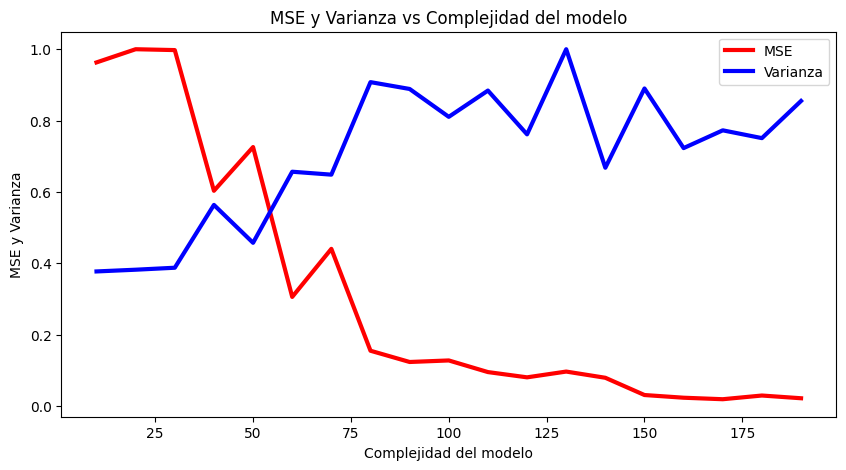

In [20]:
# bias vs variance tradeoff -- plot both mse and variance in a normalized scale
plt.figure(figsize=(10,5))
plt.xlabel('Complejidad del modelo')
plt.ylabel('MSE y Varianza')
plt.title('MSE y Varianza vs Complejidad del modelo')
# normalize the variance and mse values
vars = np.array(vars)
vars = vars / vars.max()
mse_train = np.array(mse_train)
mse_train = mse_train / mse_train.max()
plt.plot(model_complexity, mse_train, label='MSE', color='red', lw=3)
plt.plot(model_complexity, vars, label='Varianza', color='blue', lw=3)
plt.legend()
plt.show()
